In [2]:
# Libraries
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import librosa
from tensorflow.keras import regularizers
from scipy import signal
from sklearn.metrics import classification_report, accuracy_score


In [3]:
hf = h5py.File('spectrograms.h5', 'r')
class_names = list(hf.keys())

In [4]:
# Check File Structure
with h5py.File('spectrograms.h5', 'r') as f:
    # List all groups and datasets
    print("File structure:")
    def print_structure(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name}, Shape: {obj.shape}, Type: {obj.dtype}")
        else:
            print(f"Group: {name}")
    
    f.visititems(print_structure)

File structure:
Dataset: amecro, Shape: (256, 343, 52), Type: float64
Dataset: barswa, Shape: (256, 343, 55), Type: float64
Dataset: bkcchi, Shape: (256, 343, 57), Type: float64
Dataset: blujay, Shape: (256, 343, 50), Type: float64
Dataset: daejun, Shape: (256, 343, 58), Type: float64
Dataset: houfin, Shape: (256, 343, 44), Type: float64
Dataset: mallar3, Shape: (256, 343, 36), Type: float64
Dataset: norfli, Shape: (256, 343, 59), Type: float64
Dataset: rewbla, Shape: (256, 343, 41), Type: float64
Dataset: stejay, Shape: (256, 343, 40), Type: float64
Dataset: wesmea, Shape: (256, 343, 36), Type: float64
Dataset: whcspa, Shape: (256, 343, 51), Type: float64


## CNN 

## Data Prep

In [5]:
# Reading in data from .h5 file
with h5py.File('spectrograms.h5', 'r') as f:
    # Retrieving keys and data for each spectrogram  
    all_spectrograms = [f[key][()] for key in f.keys()]
    # Each spectrogram is a 3D array, 3rd dimension is the length(or time frames)
    max_length = max(spectrogram.shape[2] for spectrogram in all_spectrograms)
    # Empty list to store spectrograms
    padded_spectrograms = []
    for spectrogram in all_spectrograms:
        # Pad the spectrogram along the batch size dimension to make sure all inputs are the same size
        padded_spectrogram = np.pad(spectrogram, ((0, 0), (0, 0), (0, max_length - spectrogram.shape[2])), mode='constant')
        padded_spectrograms.append(padded_spectrogram)

# Convert to array, necessary format and data structure for CNNs
padded_spectrograms_array = np.array(padded_spectrograms)

# Concatenate the padded spectrograms along time dimension 
concatenated_spectrograms = np.concatenate(padded_spectrograms_array, axis=2)

# Transpose the spectrograms, necessary for CNN for image-like data
# (time_steps, frequency bins, channels)
spectrograms = np.transpose(concatenated_spectrograms, (2, 0, 1))

# Assign labels from 0 to 11
num_categories = len(all_spectrograms)
labels = np.concatenate([np.full((padded_spectrogram.shape[2],), i) for i in range(num_categories)])

In [6]:
# Prepare spectrograms and labels (from your existing code)
spectrograms = np.expand_dims(spectrograms, axis=-1)  # Add channel dimension
encoder = OneHotEncoder()
labels_onehot = encoder.fit_transform(labels.reshape(-1, 1)).toarray()

# First split
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    spectrograms, 
    labels_onehot, 
    test_size=0.2, 
    random_state=100,
    stratify=labels  
)

# Second split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp,
    y_train_temp,
    test_size=0.2,  # 0.2 * 0.8 = 0.16 (16% of total)
    random_state=100,
    stratify=np.argmax(y_train_temp, axis=1)  # Stratify using class indices
)

# 4. Verify shapes
print(f"Train: {X_train.shape} {y_train.shape}")
print(f"Val:   {X_val.shape} {y_val.shape}")
print(f"Test:  {X_test.shape} {y_test.shape}")

# 5. Verify class distribution
print("\nClass distribution:")
for name, split in zip(["Train", "Val", "Test"], 
                      [y_train, y_val, y_test]):
    print(f"{name}: {np.unique(np.argmax(split, axis=1), return_counts=True)}")

Train: (452, 256, 343, 1) (452, 12)
Val:   (114, 256, 343, 1) (114, 12)
Test:  (142, 256, 343, 1) (142, 12)

Class distribution:
Train: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([37, 38, 38, 37, 38, 38, 38, 38, 38, 38, 37, 37]))
Val: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([10,  9,  9, 10,  9,  9, 10,  9,  9, 10, 10, 10]))
Test: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([12, 12, 12, 12, 12, 12, 11, 12, 12, 11, 12, 12]))


In [7]:
print(X_train.shape)

(452, 256, 343, 1)


In [8]:
np.random.seed(123)
tf.random.set_seed(123)

num_classes = 12

model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 343, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

2025-03-26 09:19:50.275502: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-03-26 09:19:50.275589: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-26 09:19:50.275613: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-26 09:19:50.275716: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-26 09:19:50.275734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 341, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 170, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 170, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 690880)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    88,432,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,434,636 (337.35 MB)

 Trainable params: 88,434,636 (337.35 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True  
)

history = model1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]  
)

test_loss, test_acc = model1.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/100


2025-03-26 09:19:50.991437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-03-26 09:19:50.994369: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 329ms/step - accuracy: 0.1496 - loss: 2.4798 - val_accuracy: 0.2676 - val_loss: 2.3065
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - accuracy: 0.3497 - loss: 2.2343 - val_accuracy: 0.4014 - val_loss: 2.1033
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - accuracy: 0.4363 - loss: 2.0197 - val_accuracy: 0.4437 - val_loss: 1.9170
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - accuracy: 0.4758 - loss: 1.7958 - val_accuracy: 0.5423 - val_loss: 1.7792
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - accuracy: 0.5670 - loss: 1.5889 - val_accuracy: 0.5915 - val_loss: 1.6480
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 292ms/step - accuracy: 0.5925 - loss: 1.4862 - val_accuracy: 0.5845 - val_loss: 1.5558
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - accuracy: 0.6186 - loss: 1.3254 - val_accuracy: 0.6127 - val_loss: 1.4636
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - accuracy: 0.6549 - loss: 1.2367 - val_accuracy: 0.6408

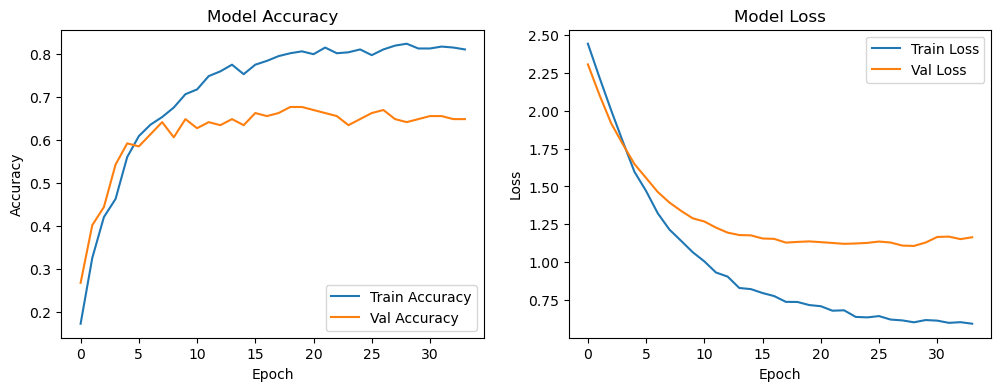

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

2025-03-26 09:22:21.261472: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


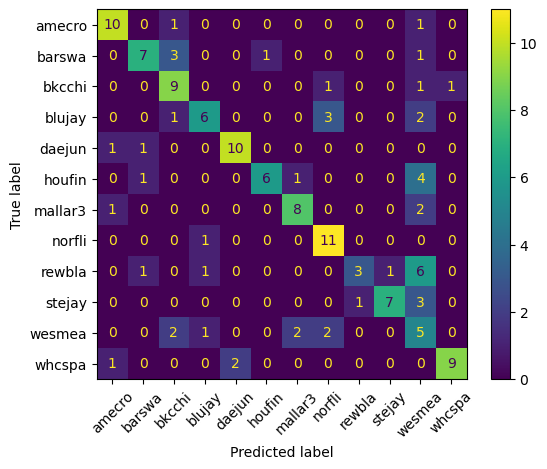

In [11]:
y_true = np.argmax(y_test, axis=1)
y_pred_prob = model1.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

cm = ConfusionMatrixDisplay.from_predictions(y_true, y_pred_classes, display_labels=class_names, xticks_rotation=45)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


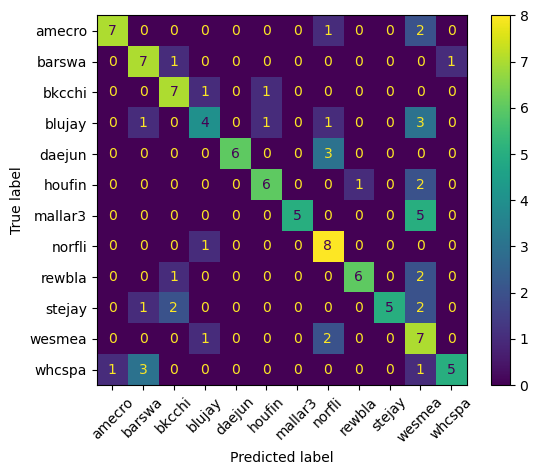

In [12]:
y_true = np.argmax(y_val, axis=1)
y_pred_prob = model1.predict(X_val)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

cm = ConfusionMatrixDisplay.from_predictions(y_true, y_pred_classes, display_labels=class_names, xticks_rotation=45)
plt.show()

In [13]:
with h5py.File('spectrograms.h5', 'r') as f:
    species_names = sorted(list(f.keys()))  # Get alphabetically sorted species names
    print("Species found:", species_names)

# Get predictions for validation and test sets
val_preds = model1.predict(X_val)
test_preds = model1.predict(X_test)

# Convert from one-hot to class indices
y_val_int = np.argmax(y_val, axis=1)
y_test_int = np.argmax(y_test, axis=1)
val_preds_int = np.argmax(val_preds, axis=1)
test_preds_int = np.argmax(test_preds, axis=1)

# Calculate metrics
print("\n" + "="*50)
print("Validation Set Metrics")
print("="*50)
print(f"Accuracy: {accuracy_score(y_val_int, val_preds_int):.4f}")
print(classification_report(y_val_int, val_preds_int, target_names=species_names))

print("\n" + "="*50)
print("Test Set Metrics")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test_int, test_preds_int):.4f}")
print(classification_report(y_test_int, test_preds_int, target_names=class_names))

Species found: ['amecro', 'barswa', 'bkcchi', 'blujay', 'daejun', 'houfin', 'mallar3', 'norfli', 'rewbla', 'stejay', 'wesmea', 'whcspa']
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Validation Set Metrics
Accuracy: 0.6404
              precision    recall  f1-score   support

      amecro       0.88      0.70      0.78        10
      barswa       0.58      0.78      0.67         9
      bkcchi       0.64      0.78      0.70         9
      blujay       0.57      0.40      0.47        10
      daejun       1.00      0.67      0.80         9
      houfin       0.75      0.67      0.71         9
     mallar3       1.00      0.50      0.67        10
      norfli       0.53      0.89      0.67         9
      rewbla       0.86      0.67      0.75         9
      stejay       1.00      0.50      0.67        10
      wesmea       0.29      0.70      0.41        10
      whcspa       0.83      0.50      0.62        10

    accuracy                           0.6

## Change in Preprocessing


In [14]:
# Load the .h5
def load_h5_data(file_path):
    X_data = []
    y_data = []
    
    with h5py.File(file_path, 'r') as hf:
        # Get all bird class keys 
        bird_keys = list(hf.keys())
        
        for class_idx, bird_key in enumerate(bird_keys):
            # Get spectrograms for bird class
            bird_specs = hf[bird_key][:]  
            
            # Create corresponding labels
            num_samples = bird_specs.shape[2]
            labels = np.full(num_samples, class_idx)
            
            X_data.append(bird_specs)
            y_data.append(labels)
    
    # Concatenate all bird data
    X_data = np.concatenate(X_data, axis=2)  
    y_data = np.concatenate(y_data)         
    
    return X_data, y_data

# Convert to Mel Spectrogram
def to_mel_spectrogram(data, sr=22050, n_mels=128, hop_length=512):
    mel_specs = []
    
    for i in range(data.shape[2]):
        spec = data[:, :, i]
        mel_spec = librosa.feature.melspectrogram(
            S=spec,
            sr=sr,
            n_mels=n_mels,
            hop_length=hop_length
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_specs.append(mel_spec_db)
    
    return np.array(mel_specs)

# Data Augmentation
def augment_spectrogram(mel_spec, max_time_shift=10, noise_factor=0.005):
    augmented = mel_spec.copy()
    
    # Time shifting
    shift = np.random.randint(-max_time_shift, max_time_shift)
    augmented = np.roll(augmented, shift, axis=1)
    
    # Add random noise
    noise = np.random.randn(*augmented.shape) * noise_factor
    augmented = augmented + noise
    
    # Frequency masking
    f = np.random.randint(0, 10)
    f0 = np.random.randint(0, augmented.shape[0] - f)
    augmented[f0:f0+f, :] = 0
    
    return augmented

# Preprocessing Pipeline
def preprocess_data(file_path, target_size=(128, 343)):
    # Load data
    data, labels = load_h5_data(file_path)
    
    # Convert to mel spectrograms
    mel_specs = to_mel_spectrogram(data)
    
    # Normalize
    mel_specs = (mel_specs - np.mean(mel_specs)) / np.std(mel_specs)
    
    # Prepare augmented dataset
    X_processed = []
    y_processed = []
    
    for i in range(len(mel_specs)):
        spec = mel_specs[i]
        spec = tf.image.resize(spec[..., np.newaxis], target_size).numpy()[..., 0]
        
        # Add original
        X_processed.append(spec)
        y_processed.append(labels[i])
        
        # Add augmented version
        aug_spec = augment_spectrogram(spec)
        X_processed.append(aug_spec)
        y_processed.append(labels[i])
    
    X_processed = np.array(X_processed)[..., np.newaxis]
    y_processed = np.array(y_processed)
    
    return X_processed, y_processed

In [15]:
def split_data(X, y, test_size=0.2, val_size=0.2, random_state=42):
    num_original_samples = len(y) // 2  # Total samples = 1158, 579 original
    original_indices = np.arange(0, len(y), 2)  # Indices of original samples
    
    # Get labels for original samples
    y_original = y[original_indices]
    
    # Split into train+val and test
    train_val_idx, test_idx = train_test_split(
        np.arange(num_original_samples),
        test_size=test_size,
        stratify=y_original,
        random_state=random_state
    )
    
    # Split train+val into train and val
    train_idx, val_idx = train_test_split(
        train_val_idx,
        test_size=val_size / (1 - test_size),  
        stratify=y_original[train_val_idx],
        random_state=random_state
    )
    
    # Convert to full indices
    train_full_idx = np.concatenate([train_idx * 2, train_idx * 2 + 1])
    val_full_idx = np.concatenate([val_idx * 2, val_idx * 2 + 1])
    test_full_idx = np.concatenate([test_idx * 2, test_idx * 2 + 1])
    
    # Sort indices
    train_full_idx.sort()
    val_full_idx.sort()
    test_full_idx.sort()
    
    # Split the data
    X_train = X[train_full_idx]
    y_train = y[train_full_idx]
    X_val = X[val_full_idx]
    y_val = y[val_full_idx]
    X_test = X[test_full_idx]
    y_test = y[test_full_idx]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

if __name__ == "__main__":
    file_path = "spectrograms.h5"
    
    # Process the data
    X, y = preprocess_data(file_path)
    
    print(f"Processed data shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    
    # Verify class distribution before split
    unique, counts = np.unique(y, return_counts=True)
    print("Original class distribution:", dict(zip(unique, counts)))
    
    # Split the data
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(
        X, y, test_size=0.2, val_size=0.2
    )
    
    # Print shapes
    print(f"Training set shape: {X_train.shape}, Labels: {y_train.shape}")
    print(f"Validation set shape: {X_val.shape}, Labels: {y_val.shape}")
    print(f"Test set shape: {X_test.shape}, Labels: {y_test.shape}")
    
    # Verify class distribution
    for name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
        unique, counts = np.unique(y_split, return_counts=True)
        print(f"{name} class distribution:", dict(zip(unique, counts)))

Processed data shape: (1158, 128, 343, 1)
Labels shape: (1158,)
Original class distribution: {0: 104, 1: 110, 2: 114, 3: 100, 4: 116, 5: 88, 6: 72, 7: 118, 8: 82, 9: 80, 10: 72, 11: 102}
Training set shape: (694, 128, 343, 1), Labels: (694,)
Validation set shape: (232, 128, 343, 1), Labels: (232,)
Test set shape: (232, 128, 343, 1), Labels: (232,)
Train class distribution: {0: 62, 1: 66, 2: 68, 3: 60, 4: 68, 5: 52, 6: 44, 7: 70, 8: 50, 9: 48, 10: 44, 11: 62}
Val class distribution: {0: 22, 1: 22, 2: 22, 3: 20, 4: 24, 5: 18, 6: 14, 7: 24, 8: 16, 9: 16, 10: 14, 11: 20}
Test class distribution: {0: 20, 1: 22, 2: 24, 3: 20, 4: 24, 5: 18, 6: 14, 7: 24, 8: 16, 9: 16, 10: 14, 11: 20}


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 126, 341, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 63, 170, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 61, 168, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 84, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 82, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 73472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     9,404,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,498,764 (36.23 MB)

 Trainable params: 9,498,764 (36.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2025-03-26 09:27:25.508112: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.1361 - loss: 3.0441 - val_accuracy: 0.3319 - val_loss: 2.7663
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.2888 - loss: 2.7081 - val_accuracy: 0.4181 - val_loss: 2.4486
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.3985 - loss: 2.4263 - val_accuracy: 0.5086 - val_loss: 2.2619
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5089 - loss: 2.1268 - val_accuracy: 0.6078 - val_loss: 1.9873
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5579 - loss: 1.9444 - val_accuracy: 0.6466 - val_loss: 1.8623
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.6675 - loss: 1.7062 - val_accuracy: 0.6767 - val_loss: 1.6778
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.7157 - loss: 1.5799 - val_accuracy: 0.6853 - val_loss: 1.5610
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.7294 - loss: 1.4150 - val_accuracy: 0.7328

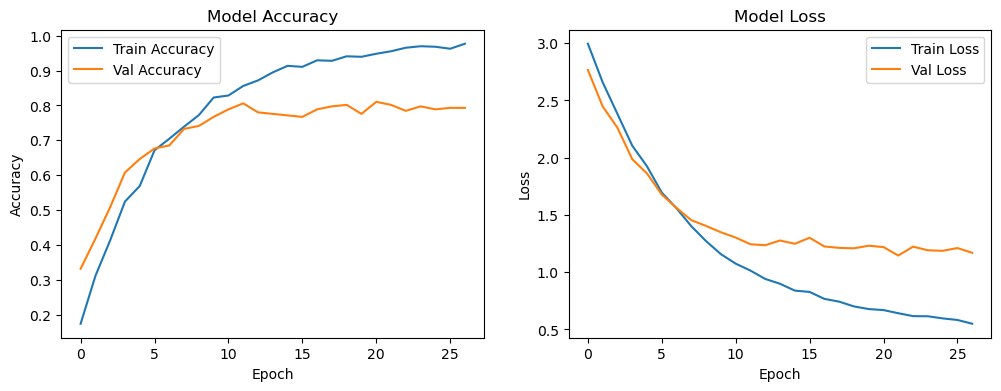

In [21]:
# Set random seeds for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

num_classes = len(np.unique(y_train))

# Convert labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes)

# 86%
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 343, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', 
                          kernel_regularizer=regularizers.l2(0.005)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', 
                          kernel_regularizer=regularizers.l2(0.005)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', 
                          kernel_regularizer=regularizers.l2(0.005)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),    
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Model summary
model.summary()

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train_onehot,
    validation_data=(X_val, y_val_onehot), 
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Start higher
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=3,
#     min_lr=1e-6
# )

# from sklearn.utils.class_weight import compute_class_weight
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weights_dict = dict(enumerate(class_weights))

# history = model.fit(
#     X_train, y_train_onehot,
#     validation_data=(X_val, y_val_onehot),
#     epochs=100,
#     batch_size=32,
#     callbacks=[early_stopping, lr_scheduler],
#     class_weight=class_weights_dict
# )

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test_onehot)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step

2025-03-26 09:30:16.538738: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


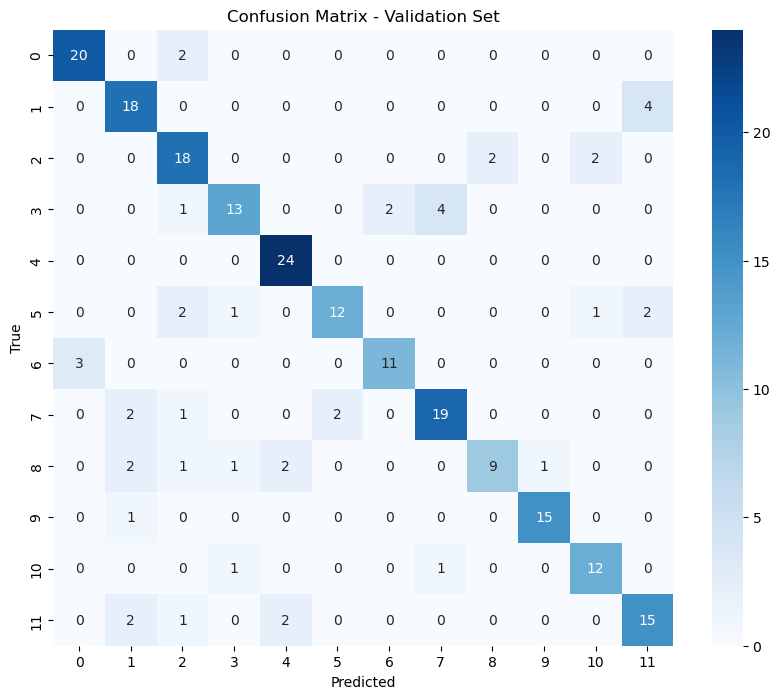

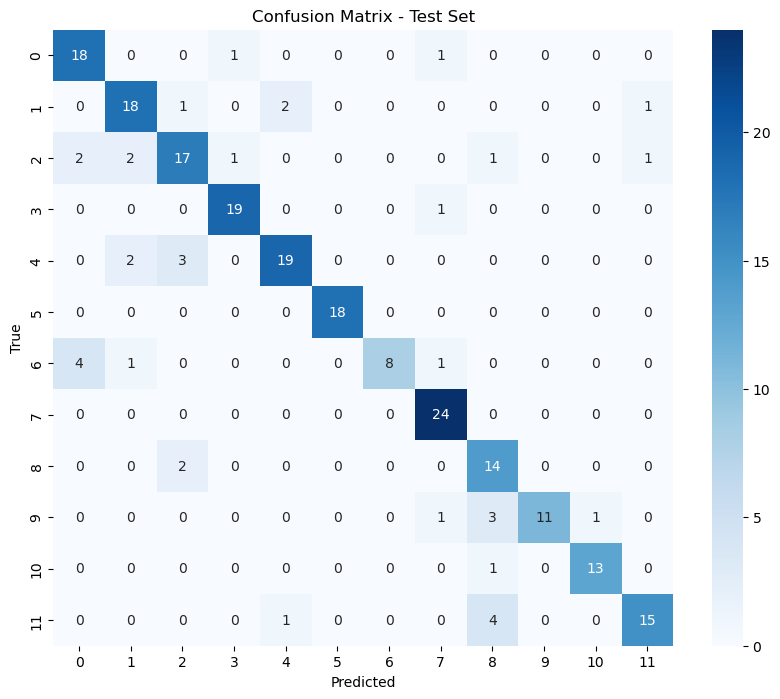

In [22]:
import seaborn as sns
# Get predictions for validation and test sets
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

# Convert one-hot encoded labels to integer labels
y_val_int = np.argmax(y_val_onehot, axis=1)  
y_test_int = np.argmax(y_test_onehot, axis=1)

# Convert predictions to integer labels
val_preds_int = np.argmax(val_preds, axis=1)
test_preds_int = np.argmax(test_preds, axis=1)

# Compute confusion matrices
cm_val = confusion_matrix(y_val_int, val_preds_int)
cm_test = confusion_matrix(y_test_int, test_preds_int)


class_names = [str(i) for i in range(num_classes)] 

# Plot confusion matrix for validation set
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot confusion matrix for test set
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
# Calculate metrics
print("\n" + "="*50)
print("Validation Set Metrics")
print("="*50)
print(f"Accuracy: {accuracy_score(y_val_int, val_preds_int):.4f}")
print(classification_report(y_val_int, val_preds_int, target_names=species_names))

print("\n" + "="*50)
print("Test Set Metrics")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test_int, test_preds_int):.4f}")
print(classification_report(y_test_int, test_preds_int, target_names=species_names))


Validation Set Metrics
Accuracy: 0.8017
              precision    recall  f1-score   support

      amecro       0.87      0.91      0.89        22
      barswa       0.72      0.82      0.77        22
      bkcchi       0.69      0.82      0.75        22
      blujay       0.81      0.65      0.72        20
      daejun       0.86      1.00      0.92        24
      houfin       0.86      0.67      0.75        18
     mallar3       0.85      0.79      0.81        14
      norfli       0.79      0.79      0.79        24
      rewbla       0.82      0.56      0.67        16
      stejay       0.94      0.94      0.94        16
      wesmea       0.80      0.86      0.83        14
      whcspa       0.71      0.75      0.73        20

    accuracy                           0.80       232
   macro avg       0.81      0.80      0.80       232
weighted avg       0.81      0.80      0.80       232


Test Set Metrics
Accuracy: 0.8362
              precision    recall  f1-score   support

  

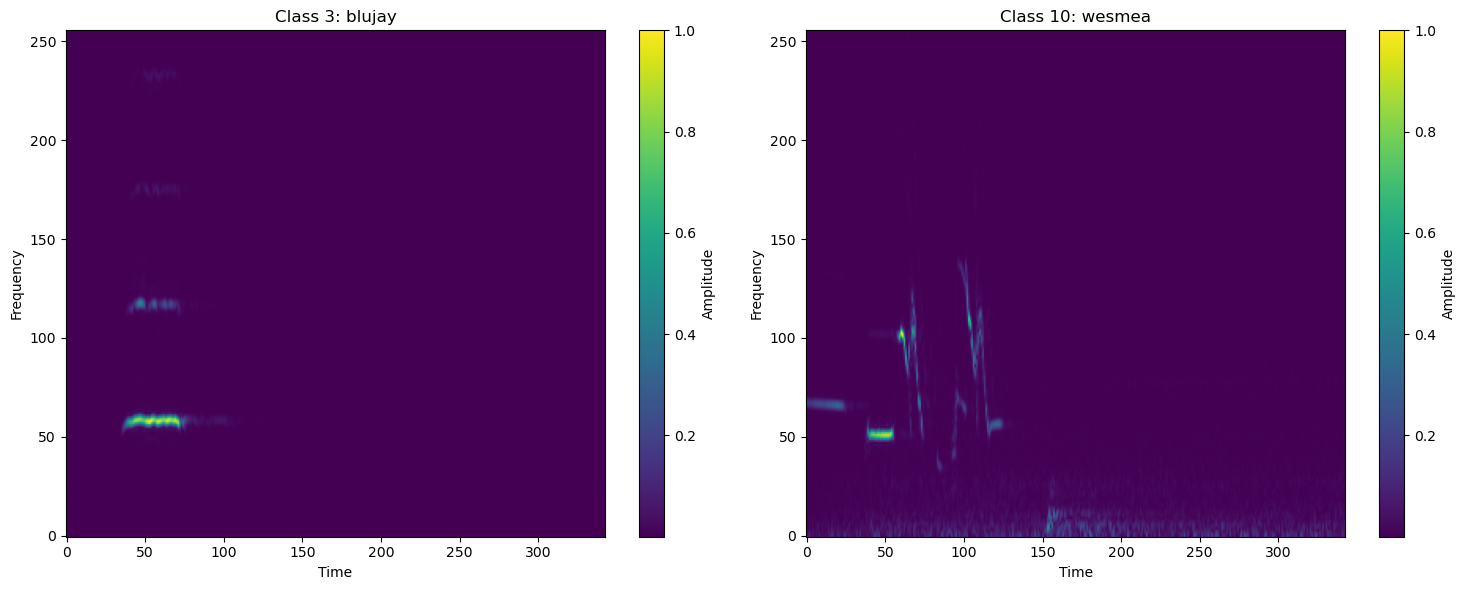

In [19]:
# Load the raw data from the HDF5 file
file_path = "spectrograms.h5"
with h5py.File(file_path, 'r') as hf:
    # Get all bird class keys
    bird_keys = list(hf.keys())
    
    # Assuming class 3 and class 10 correspond to indices 3 and 10 in bird_keys
    # (Adjust if your class indexing differs)
    class_3_key = bird_keys[3]  # e.g., species name for class 3
    class_10_key = bird_keys[10]  # e.g., species name for class 10
    
    # Load spectrograms for class 3 and class 10
    class_3_specs = hf[class_3_key][:]  # Shape: (256, 343, num_samples_per_bird)
    class_10_specs = hf[class_10_key][:]  # Shape: (256, 343, num_samples_per_bird)
    
    # Select the first spectrogram from each class (index 0 along sample axis)
    spec_3 = class_3_specs[:, :, 0]  # Shape: (256, 343)
    spec_10 = class_10_specs[:, :, 0]  # Shape: (256, 343)

# Create subplots for visualization
plt.figure(figsize=(15, 6))

# Plot class 3 spectrogram
plt.subplot(1, 2, 1)
plt.imshow(spec_3, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title(f'Class 3: {class_3_key}')
plt.xlabel('Time')
plt.ylabel('Frequency')

# Plot class 10 spectrogram
plt.subplot(1, 2, 2)
plt.imshow(spec_10, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title(f'Class 10: {class_10_key}')
plt.xlabel('Time')
plt.ylabel('Frequency')

# Adjust layout and display
plt.tight_layout()
plt.show()